In [14]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
# Téléchargez les ressources nécessaires pour NLTK
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
!pip install unidecode


In [17]:
import pandas as pd
import string
from unidecode import unidecode
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import nltk
from nltk.corpus import stopwords
stopwords_fr = stopwords.words('french')
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional

from keras.layers import Dense
from keras import regularizers

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer

# Créer un dictionnaire français à partir des mots français contenus dans la liste des mots français du corpus nltk
fr_dict = set(stopwords.words('french'))

from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

In [18]:
df = pd.read_csv("../input/french-twitter-sentiment-analysis/french_tweets.csv") 
print(df.dtypes)
print(df.head())

label     int64
text     object
dtype: object
   label                                               text
0      0  - Awww, c'est un bummer. Tu devrais avoir davi...
1      0  Est contrarié qu'il ne puisse pas mettre à jou...
2      0  J'ai plongé plusieurs fois pour la balle. A ré...
3      0  Tout mon corps a des démangeaisons et comme si...
4      0  Non, il ne se comporte pas du tout. je suis en...


In [19]:
df_echantillon = df.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 100000)))

# Vérifiez la répartition des labels dans l'échantillon
repartition_labels = df_echantillon['label'].value_counts()
print(repartition_labels)

label
0    100000
1    100000
Name: count, dtype: int64


/tmp/ipykernel_35/2360260494.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_echantillon = df.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 100000)))


In [20]:
def clean_text(text):
    # lowercase
    text = text.lower()
    # remove tags
    text = re.sub("&lt;/?.*?&gt;", " &lt;&gt; ", text)
    text = re.sub(r'[@/#]', '', text)
    # remove special characters and digits
    text = re.sub("(\\d|\\W)+", " ", text)
    text = re.sub(r'_+', '', text)
    # Remove accents
    text = unidecode(text)
    # Tokenization
    tokens = nltk.word_tokenize(text)
    # Supprime les valeurs n'étant pas dans le bon alphabet
    text = ' '.join(tokens)
    # url
    text = re.sub(r'http\S+', '', text)
    # Supprime les valeurs vides
    text = re.sub(r'\s+', ' ', text).strip()
    return text



def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


df_echantillon['text']=df_echantillon['text'].apply(clean_text)
df_echantillon['text'] = df_echantillon['text'].apply(remove_emoji)
df_echantillon.head()

,label,text
314182,0,personne moi aucun je me sens tellement droit
736790,0,sanglante le nouvel album queen paul rodgers s...
148629,0,je ne trouve pas son email
196063,0,wtf que se passe t il omg quel genre de balein...
419084,0,accroche a mon nan lt puis a l airpogoing pour...


In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_echantillon['text'])
X = tokenizer.texts_to_sequences(df_echantillon['text'])
X = pad_sequences(X)
y = np.array(df_echantillon['label'])
X = np.reshape(X, (X.shape[0],X.shape[1],1))
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Supposons que vous ayez des données textuelles dans une liste appelée "texts"
texts = df_echantillon['text'].tolist()

# Taille du vocabulaire
vocab_size = 1000  # Par exemple

# Taille de l'espace d'embedding
embedding_dim = 100  # Par exemple

# Créer un tokenizer
tokenizer = Tokenizer(num_words=vocab_size)

# Adapter le tokenizer sur les textes
tokenizer.fit_on_texts(texts)

# Convertir les textes en séquences d'entiers
sequences = tokenizer.texts_to_sequences(texts)

# Longueur maximale des séquences (à adapter en fonction de vos données)
max_len = 100  # Par exemple

# Obtenez la matrice des séquences
X = pad_sequences(sequences, maxlen=max_len)

# Données de sortie
y = np.array(df_echantillon['label'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          100000    
                                                                 
 bidirectional (Bidirection  (None, 100, 256)          234496    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 100, 256)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128)               0     

I0000 00:00:1708892763.021058     131 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4000/4000 [==============================] - 94s 22ms/step - loss: 0.5193 - accuracy: 0.7411 - val_loss: 0.4930 - val_accuracy: 0.7561
Epoch 2/15
4000/4000 [==============================] - 70s 18ms/step - loss: 0.4852 - accuracy: 0.7630 - val_loss: 0.4846 - val_accuracy: 0.7624
Epoch 3/15
4000/4000 [==============================] - 71s 18ms/step - loss: 0.4733 - accuracy: 0.7706 - val_loss: 0.4819 - val_accuracy: 0.7625
Epoch 4/15
4000/4000 [==============================] - 70s 17ms/step - loss: 0.4639 - accuracy: 0.7759 - val_loss: 0.4853 - val_accuracy: 0.7650
Epoch 5/15
4000/4000 [==============================] - 70s 17ms/step - loss: 0.4542 - accuracy: 0.7813 - val_loss: 0.4822 - val_accuracy: 0.7642
Epoch 6/15
4000/4000 [==============================] - 70s 18ms/step - loss: 0.4431 - accuracy: 0.7866 - val_loss: 0.4890 - val_accuracy: 0.7657
Epoch 7/15
4000/4000 [==============================] - 70s 18ms/step - loss: 0.4301 - accuracy: 0.7943 - val_loss: 0.4890 - val_accura

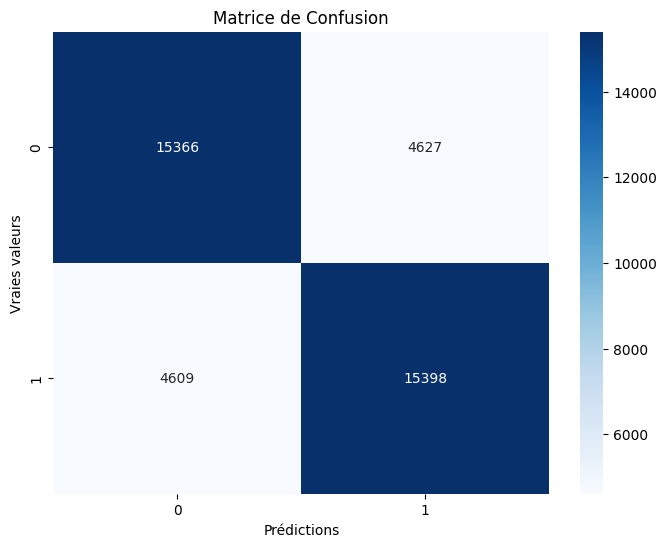

In [23]:
# Modèle avec des couches BiLSTM
inputs_bi = Input(shape=(max_len,))
# Couche d'embedding
embedding_layer_bi = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(inputs_bi)

# Couches BiLSTM
x_bi = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer_bi)
x_bi = Dropout(0.2)(x_bi)
x_bi = Bidirectional(LSTM(64))(x_bi)
x_bi = Dropout(0.2)(x_bi)

# Couche de sortie
outputs_bi = Dense(1, activation='sigmoid')(x_bi)

# Créer le modèle BiLSTM
modeleBi = Model(inputs=inputs_bi, outputs=outputs_bi)

modeleBi.summary()

learning_rate = 0.001  # Par exemple, vous pouvez choisir 0.001

# Créer un optimiseur Adam avec le learning rate spécifié
optimizer = Adam(learning_rate=learning_rate)

# Compiler le modèle avec l'optimiseur personnalisé
modeleBi.compile(loss='binary_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définir EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entraînement du modèle avec EarlyStopping et validation_split
history_bi = modeleBi.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Évaluation du modèle BiLSTM
loss_bi, accuracy_bi = modeleBi.evaluate(X_test, y_test)
print("Test Loss (BiLSTM):", loss_bi)
print("Test Accuracy (BiLSTM):", accuracy_bi)

# Faire des prédictions sur l'ensemble de test
y_pred = modeleBi.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Visualiser la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()

In [24]:
modeleBi.save("bilstm100000.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
